# Dog Breed Classification

## Objective:

The goal of this project is to build a deep learning model that can accurately classify different dog breeds based on input images.


## 1. Importing the Necessary Packages

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam

## 2. Data Exploration

We extracted the data from Kaggle's "Dog Breed Identification" competition (https://www.kaggle.com/competitions/dog-breed-identification/overview). The dataset contains two main columns in the labels csv.

1. "id": This column contains unique identifiers (IDs) corresponding to the pictures of various dog breeds found in the "train" folder.
2. "breed": This column indicates the specific breed of the dog in the picture corresponding to each ID.

The combination of these two columns provides a mapping between the images and the dog breeds found in the "train" folder and their corresponding breed. This is an example of how the data is displayed: 

In [2]:
labels = pd.read_csv("labels.csv")
print(labels.head())
print(labels.shape)

                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever
(10222, 2)


As we can see, there is 10,222 different unique pictures. Now we can check how many different dog breeds there are.

In [3]:
breeds = labels["breed"]
breeds_counts = breeds.value_counts()
print(breeds_counts)

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
brabancon_griffon        67
komondor                 67
eskimo_dog               66
briard                   66
Name: breed, Length: 120, dtype: int64


Given the dataset contains 10,222 distinct images across 120 dog breeds, we have opted to streamline the computational demands of our model. To achieve this, we have extracted a subset of three different dog breeds from the dataset. This approach enables us to effectively reduce the computational intensity while retaining the integrity of the project. The displayed dataset is the subset that we will be using for this section.

In [25]:
BREED_NAMES = ["golden_retriever", "bernese_mountain_dog", "maltese_dog"]
subset_labels = labels[(labels['breed'].isin(BREED_NAMES))]
subset_labels = subset_labels.reset_index()
print(subset_labels)

     index                                id                 breed
0        4  0021f9ceb3235effd7fcde7f7538ed62      golden_retriever
1       12  00693b8bc2470375cc744a6391d397ec           maltese_dog
2       25  00a366d4b4a9bbb6c8a63126697b7656      golden_retriever
3       37  0100f55e4f0fe28f2c0465d3fc4b9897      golden_retriever
4       90  022b34fd8734b39995a9f38a4f3e7b6b           maltese_dog
..     ...                               ...                   ...
293  10172  febcab8eb2da444bf83336cffec7eb92      golden_retriever
294  10178  fef5d4cdaf50cf159102e803c7d6aa9c  bernese_mountain_dog
295  10198  ff6f47aa8e181b6efa4d0be7b09b5628      golden_retriever
296  10200  ff7d9c08091acc3b18b869951feeb013           maltese_dog
297  10204  ffa0055ec324829882186bae29491645           maltese_dog

[298 rows x 3 columns]


## 3. Image Processing

In this following section, we will set up a image processing pipeline. We created "X_data" to serve as a repository for the image data,while "Y_data" is designated to contain the hot-encoded labels for the selected dog breeds. Within the loop, every image located in the "train" folder and belonging to the subset dataset undergoes a transformation into an array and subsequent normalization.

In [26]:
X_data = np.zeros((len(subset_labels), 224, 224 , 3), dtype='float32')
Y_data = label_binarize(subset_labels['breed'], classes = BREED_NAMES)


for i in tqdm(range(len(subset_labels))):
    images = image.load_img('train/%s.jpg' % subset_labels['id'][i], target_size=(224,224))
    images = image.img_to_array(images)
    x = np.expand_dims(images.copy(), axis = 0)
    X_data[i] = x / 255

print("\n Train data shape: ", X_data.shape)
print("One hot endcoding shape: ", Y_data.shape)

100%|██████████| 298/298 [00:01<00:00, 251.67it/s]


 Train data shape:  (298, 224, 224, 3)
One hot endcoding shape:  (298, 3)


## 4. Model Building (CNN without Transfer Learning)

We start the model building process by splitting the data. Initially, we split the subset data into a train/validation set and a test set with 80% of the data in the train/validation set and the remaining 20% in the test set. Additionally, within the train/validation set, we implement a subsequent 90/10 division, resulting in a 90% proportion for training and a 10% proportion for validation.

In [27]:
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X_data, Y_data, test_size = 0.2)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size = 0.1)

We implement image augmentation to help improve accuracy from the model.

In [7]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

The following code segment encompasses the creation of the construction of the CNN model.  The model architecture consists of several convolutional and pooling layers, designed to extract hierarchical features from input images. It further comprises fully connected layers to enable the classification of different dog breeds. The training process includes early stopping to prevent overfitting and restore the best weights. After training, the model's performance is assessed using the validation dataset, while test accuracy is evaluated on a distinct test set. This approach aims to develop a robust classifier capable of identifying various dog breeds, and its efficacy is gauged through its performance on the evaluation set.

In [9]:
def create_model():
    model = Sequential([
        Conv2D(filters=32, kernel_size=(3, 3), activation="relu", input_shape=(224, 224, 3)),
        MaxPool2D(pool_size=2),
        Conv2D(filters=64, kernel_size=(3, 3), activation="relu"),
        MaxPool2D(pool_size=2),
        Conv2D(filters=128, kernel_size=(3, 3), activation="relu"),
        MaxPool2D(pool_size=2),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(len(BREED_NAMES), activation='softmax')
    ])

    model.compile(
        loss='categorical_crossentropy',
        optimizer= Adam(0.001),
        metrics=['accuracy']
    )
    
    return model

# Train the model
early_stopping = EarlyStopping(patience=10, restore_best_weights=True, monitor='val_accuracy')
model = create_model()
history = model.fit(
    datagen.flow(X_train, Y_train, batch_size=32),
    steps_per_epoch=len(X_train) // 32,
    epochs=100,
    validation_data=(X_val, Y_val),
    callbacks=[early_stopping]
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, Y_test)
print("Test Accuracy:", test_accuracy)


Epoch 1/100
6/6 [==============================] - 13s 2s/step - loss: 1.5425 - accuracy: 0.3187 - val_loss: 1.0847 - val_accuracy: 0.1667
Epoch 2/100
6/6 [==============================] - 10s 2s/step - loss: 1.0921 - accuracy: 0.3352 - val_loss: 1.0836 - val_accuracy: 0.1667
Epoch 3/100
6/6 [==============================] - 10s 2s/step - loss: 1.0900 - accuracy: 0.3791 - val_loss: 1.0842 - val_accuracy: 0.1667
Epoch 4/100
6/6 [==============================] - 11s 2s/step - loss: 1.0902 - accuracy: 0.3901 - val_loss: 1.0656 - val_accuracy: 0.1667
Epoch 5/100
6/6 [==============================] - 10s 2s/step - loss: 1.0591 - accuracy: 0.4121 - val_loss: 1.0321 - val_accuracy: 0.1667
Epoch 6/100
6/6 [==============================] - 11s 2s/step - loss: 1.0051 - accuracy: 0.4451 - val_loss: 0.9079 - val_accuracy: 0.7500
Epoch 7/100
6/6 [==============================] - 10s 2s/step - loss: 0.9191 - accuracy: 0.5440 - val_loss: 0.8588 - val_accuracy: 0.8333
Epoch 8/100
6/6 [==========

In [ ]:
df = pd.DataFrame(history.history)
df.loc[:, ['loss', 'val_loss']].plot()
df.loc[:, ['accuracy', 'val_accuracy']].plot()

The model we created has a 78.33% accuracy when compared to the test set. We display the initial labels with the predicted labels produced by the images of the dogs.

2/2 [==============================] - 8s 343ms/step


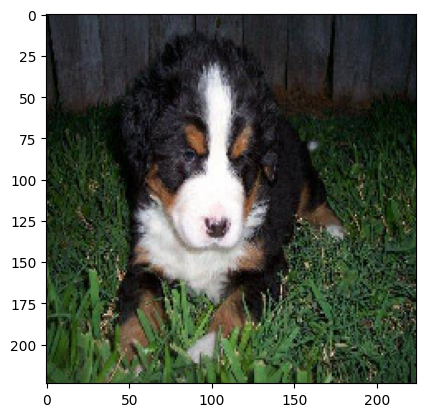

Initial Label:  bernese_mountain_dog
Predicted Label:  bernese_mountain_dog


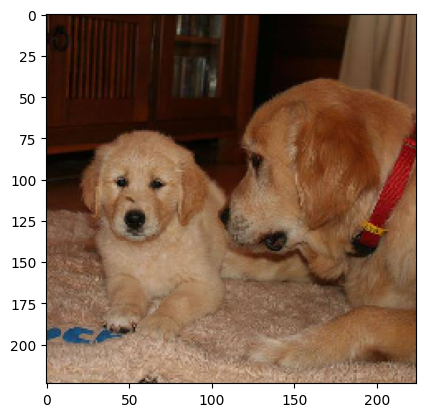

Initial Label:  golden_retriever
Predicted Label:  golden_retriever


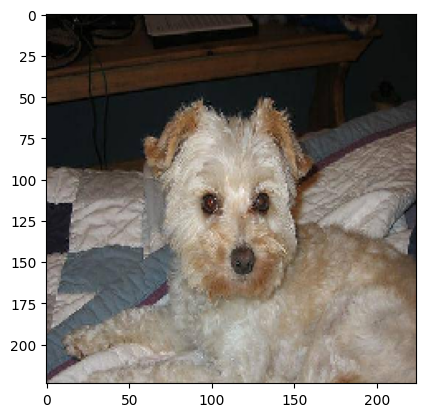

Initial Label:  maltese_dog
Predicted Label:  maltese_dog


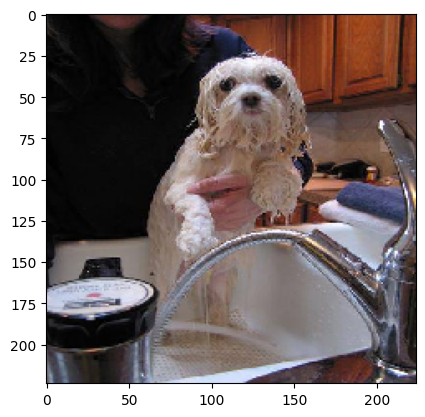

Initial Label:  maltese_dog
Predicted Label:  maltese_dog


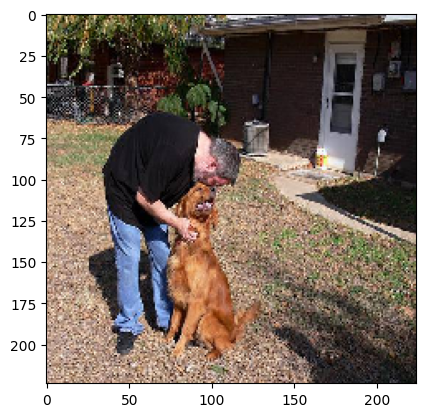

Initial Label:  golden_retriever
Predicted Label:  maltese_dog


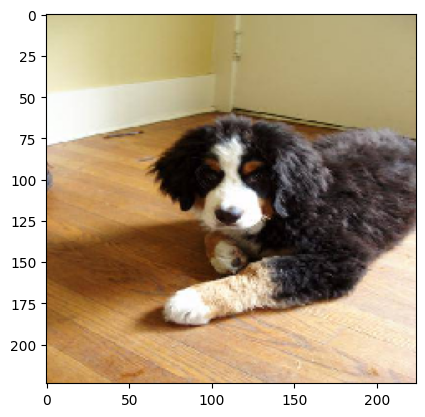

Initial Label:  bernese_mountain_dog
Predicted Label:  bernese_mountain_dog


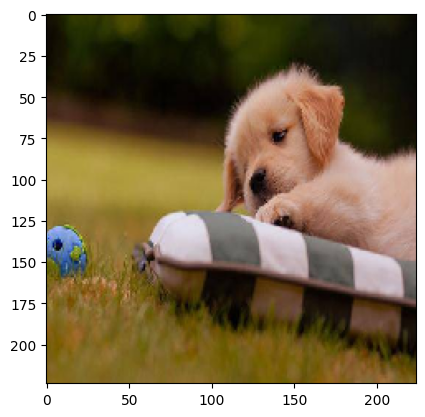

Initial Label:  golden_retriever
Predicted Label:  maltese_dog


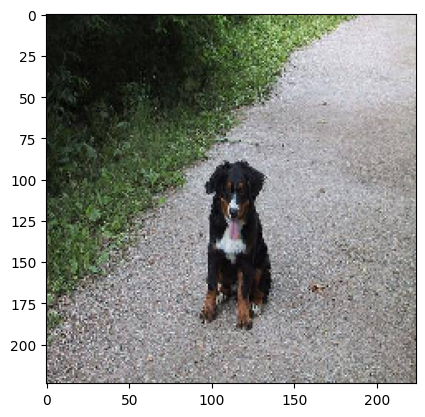

Initial Label:  bernese_mountain_dog
Predicted Label:  maltese_dog


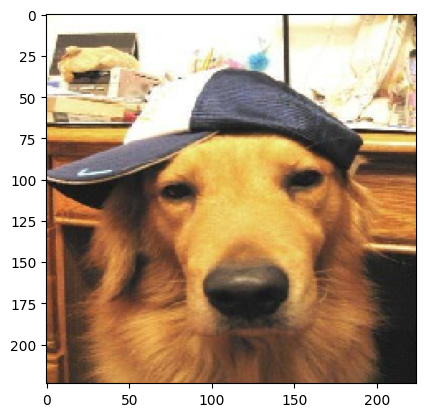

Initial Label:  golden_retriever
Predicted Label:  golden_retriever


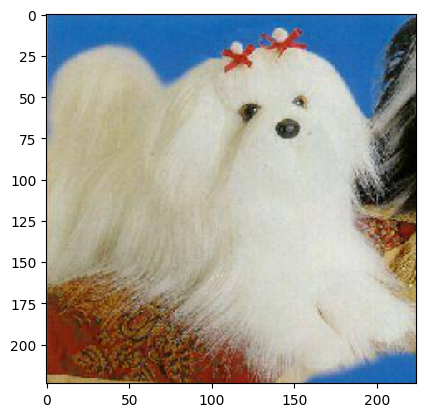

Initial Label:  maltese_dog
Predicted Label:  maltese_dog


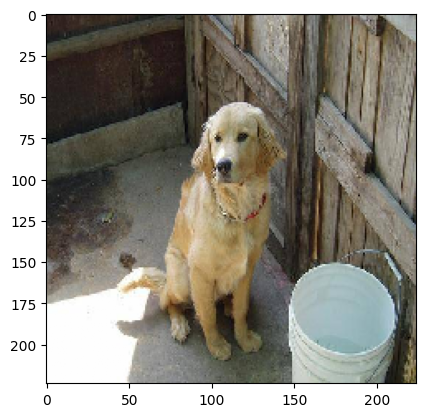

Initial Label:  golden_retriever
Predicted Label:  golden_retriever


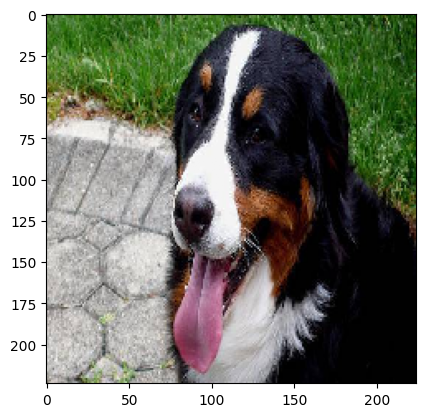

Initial Label:  bernese_mountain_dog
Predicted Label:  bernese_mountain_dog


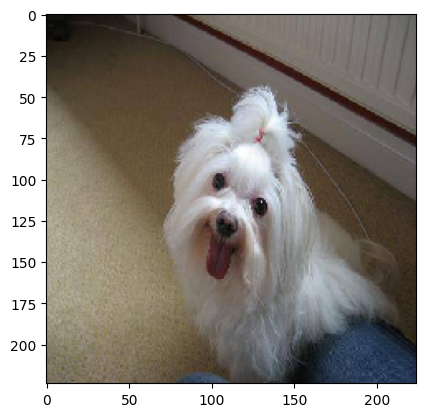

Initial Label:  maltese_dog
Predicted Label:  maltese_dog


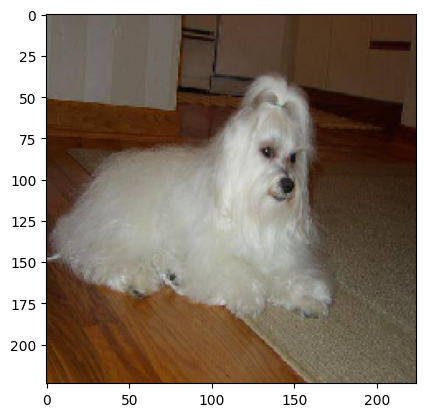

Initial Label:  maltese_dog
Predicted Label:  maltese_dog


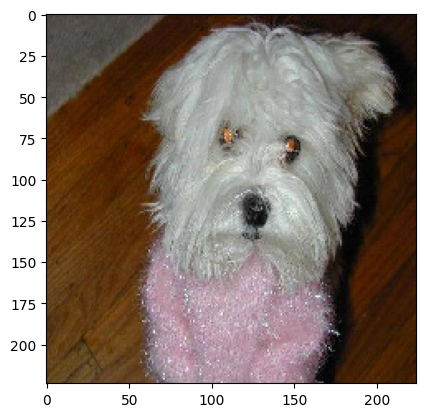

Initial Label:  maltese_dog
Predicted Label:  maltese_dog


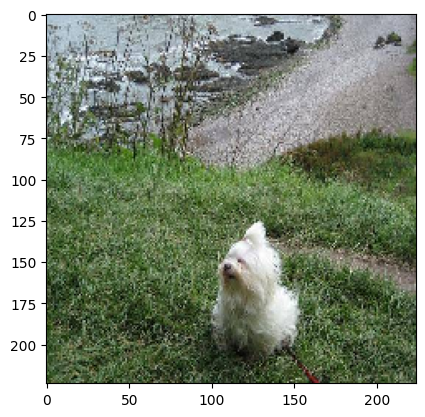

Initial Label:  maltese_dog
Predicted Label:  maltese_dog


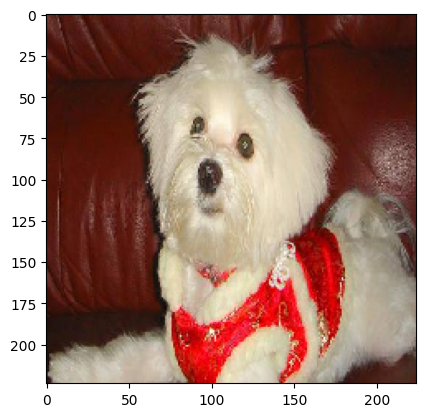

Initial Label:  maltese_dog
Predicted Label:  golden_retriever


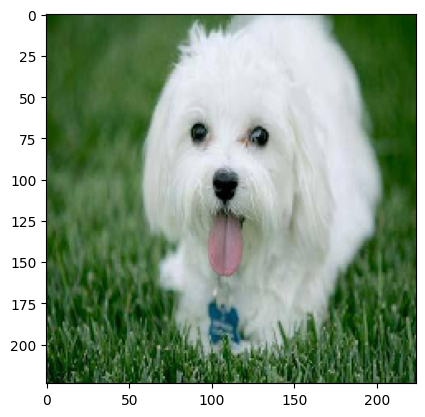

Initial Label:  maltese_dog
Predicted Label:  maltese_dog


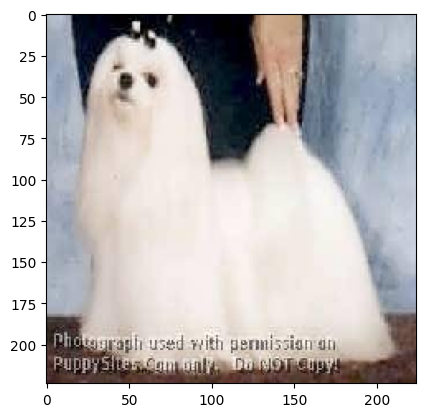

Initial Label:  maltese_dog
Predicted Label:  maltese_dog


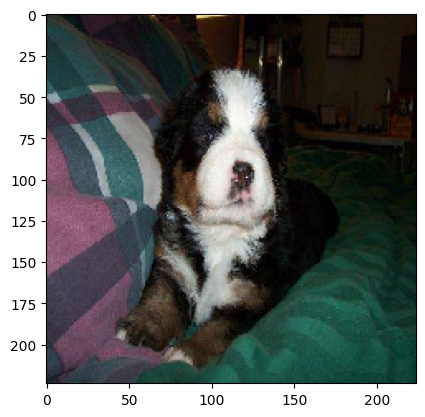

Initial Label:  bernese_mountain_dog
Predicted Label:  bernese_mountain_dog


In [28]:
predictions = model.predict(X_test)

predicted_breed_indices = np.argmax(predictions, axis=1)
predicted_breeds = [BREED_NAMES[i] for i in predicted_breed_indices]

actual_breed_indices = np.argmax(Y_test, axis=1)
actual_breeds = [BREED_NAMES[i] for i in actual_breed_indices]

for i in range (20):
    plt.imshow(X_test[i,:,:,:])
    plt.show()

    print("Initial Label: ", actual_breeds[i])
    print("Predicted Label: ", predicted_breeds[i])  